# Titre projet

In [192]:
from fredapi import Fred
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from numpy.linalg import svd

import pandas as pd
from pathlib import Path
import re
import requests

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist

from typing import Optional, Dict, Tuple
import os

# from skfin.dataloaders.cache import CacheManager


## Récupération et préparation des données


### Données FRED

In [193]:
def load_fred_md():
    # Dataset principal
    url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
    df = pd.read_csv(url_data, index_col=0)

    # Conversion de l'index en dates si possible
    try:
        df.index = pd.to_datetime(df.index)
    except:
        pass

    return df

def load_transform_codes():
    url_codes = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/FRED-MD_updated_appendix.csv"
    # cp1252 (a.k.a. windows-1252) fixes the 0x92 decode error
    return pd.read_csv(url_codes, encoding="cp1252")  # or encoding="latin1"


# Chargement des deux fichiers
df = load_fred_md()
transform_codes = load_transform_codes()

In [194]:

# df.head(), transform_codes.head()

In [195]:
# CACHE_DIR = Path("data")
# CACHE_DIR.mkdir(parents=True, exist_ok=True)

# cm = CacheManager(cache_dir=CACHE_DIR)

# FILENAME = CACHE_DIR / "FRED_MD.parquet"

# # Sauvegarde correcte des deux DataFrames
# cm.save_to_cache(df, FILENAME)

In [196]:
print("\nTypes de données :")
print(df.dtypes)

# Vérification des doublons
n_duplicates = df.duplicated().sum()
print(f"\nNombre de lignes dupliquées : {n_duplicates}")

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Types de données :
RPI                float64
W875RX1            float64
DPCERA3M086SBEA    float64
CMRMTSPLx          float64
RETAILx            float64
                    ...   
UMCSENTx           float64
DTCOLNVHFNM        float64
DTCTHFNM           float64
INVEST             float64
VIXCLSx            float64
Length: 126, dtype: object

Nombre de lignes dupliquées : 0

Valeurs manquantes par colonne :


CMRMTSPLx          1
PERMIT            12
PERMITNE          12
PERMITMW          12
PERMITS           12
PERMITW           12
ACOGNO           398
ANDENOx          109
BUSINVx            1
ISRATIOx           1
NONREVSL           1
CONSPI             1
S&P div yield      2
S&P PE ratio       1
CP3Mx              1
COMPAPFFx          1
TWEXAFEGSMTHx    168
UMCSENTx         154
DTCOLNVHFNM        1
DTCTHFNM           1
VIXCLSx           42
dtype: int64

Dans un premier temps, nous avons inspecté la base de données afin d’identifier la présence éventuelle de doublons ainsi que le taux de valeurs manquantes par série.

Pour garantir un panel cohérent et exploitable en analyse factorielle et en apprentissage statistique, nous avons effectué les étapes suivantes :
- Restriction de l’échantillon à la période 1962-05 à 2025-07 : on élimine les observations trop anciennes ou trop récentes où plusieurs variables ne sont pas encore disponibles. Cela réduit l’impact des fortes valeurs manquantes en début et fin de série
- Suppression de quatre variables qui contiennent trop peu d’observations.

In [197]:
# 1) Conversion obligatoire de l’index en datetime
df.index = pd.to_datetime(df.index, errors="coerce")
df = df.sort_index()

cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
df = df.drop(columns=cols_to_drop, errors="ignore")
import pandas as pd
import numpy as np

df = df.loc[df.index >= "1962-05-01"].sort_index()


def trailing_nans(s: pd.Series) -> int:
    """Compte le nombre de NaN consécutifs à la fin de la série."""
    if not s.isna().any():
        return 0
    return int(np.argmax(~s[::-1].isna().values)) if s.isna().any() else 0

nan_trails = {col: trailing_nans(df[col]) for col in df.columns}
nan_trails = {k: v for k, v in nan_trails.items() if v > 0}

print("Variables avec des NaN en fin de série :")
for var, n in nan_trails.items():
    print(f"  {var:<25} → {n} observations manquantes en bas")


# Décale de 'n' mois les séries ayant n NaN en fin de période
for col, lag in nan_trails.items():
    if lag > 0:
        df[col] = df[col].shift(lag)
        print(f"Décalage appliqué sur {col:<25} : {lag} mois")

df = df.dropna(how="any")

print(f"\nTaille finale du dataset : {df.shape[0]} observations, {df.shape[1]} variables")


Variables avec des NaN en fin de série :
  CMRMTSPLx                 → 1 observations manquantes en bas
  BUSINVx                   → 1 observations manquantes en bas
  ISRATIOx                  → 1 observations manquantes en bas
  NONREVSL                  → 1 observations manquantes en bas
  CONSPI                    → 1 observations manquantes en bas
  S&P div yield             → 2 observations manquantes en bas
  S&P PE ratio              → 1 observations manquantes en bas
  DTCOLNVHFNM               → 1 observations manquantes en bas
  DTCTHFNM                  → 1 observations manquantes en bas
Décalage appliqué sur CMRMTSPLx                 : 1 mois
Décalage appliqué sur BUSINVx                   : 1 mois
Décalage appliqué sur ISRATIOx                  : 1 mois
Décalage appliqué sur NONREVSL                  : 1 mois
Décalage appliqué sur CONSPI                    : 1 mois
Décalage appliqué sur S&P div yield             : 2 mois
Décalage appliqué sur S&P PE ratio              : 

La variable VIX présente deux valeurs manquantes, que nous pouvons pour le moment nous permetre de conserver puisque cette variable ne subit pas de transformation (t-code 1), ces deux variables disparaitront lorsque nous enleverons les Na apprès la transformation des autres varibales.

A part le VIX, il ne reste plus que trois valeurs manquantes dans le dataframe, nous les remplassons par la dernière valeur connue.

In [198]:
# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])
df.head()


Valeurs manquantes par colonne :


Series([], dtype: int64)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-07-01,2960.008,2769.4,17.135,293308.8034,19741.56573,25.4023,27.3468,26.2846,37.1248,23.2271,...,64.096,18.645,10.979,2.39,2.90,2.27,7242.0,16228.0,87.7873,19.5715
1962-08-01,2964.773,2772.5,17.183,291713.9599,19864.30287,25.4292,27.3468,26.2295,36.6989,22.9038,...,64.104,18.696,10.989,2.40,2.90,2.28,7344.0,16453.0,87.8828,15.7942
1962-09-01,2966.166,2775.8,17.375,298514.3889,19923.65936,25.5905,27.5190,26.3397,36.9312,23.2023,...,64.159,18.913,10.997,2.40,2.91,2.28,7442.0,16685.0,88.2080,18.3148
1962-10-01,2981.840,2785.0,17.289,293815.9271,20236.53848,25.6174,27.4329,26.3673,36.8538,23.3018,...,63.860,18.865,11.010,2.40,2.91,2.29,7407.0,16758.0,89.7636,25.9671
1962-11-01,2992.828,2798.3,17.519,299684.9733,20342.17291,25.7249,27.6050,26.4775,37.0861,23.3266,...,63.883,18.862,11.027,2.41,2.93,2.29,7453.0,16883.0,89.7457,16.7658


In [199]:
print("\nInfo générale :")
df.info()

print("\nStatistiques descriptives :")
display(df.describe().T)
display(df.tail())
display(df.head())


Info générale :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757 entries, 1962-07-01 to 2025-08-01
Columns: 122 entries, RPI to VIXCLSx
dtypes: float64(98), int64(24)
memory usage: 727.4 KB

Statistiques descriptives :


,count,mean,std,min,25%,50%,75%,max
RPI,757.0,10060.306425,5029.911155,2960.00800,5732.6670,8840.9180,1.387718e+04,2.291842e+04
W875RX1,757.0,8550.161691,3972.858089,2769.40000,5093.2000,7597.7000,1.171940e+04,1.673990e+04
DPCERA3M086SBEA,757.0,59.615032,30.551716,17.13500,33.0680,52.5900,8.516200e+01,1.248050e+02
CMRMTSPLx,757.0,860467.820772,377680.022390,291713.95990,524334.1780,776545.9350,1.205143e+06,1.565742e+06
RETAILx,757.0,234678.170455,190988.945647,19741.56573,66280.0710,181077.0000,3.619790e+05,7.320100e+05
...,...,...,...,...,...,...,...,...
CES3000000008,757.0,12.449696,7.152718,2.27000,5.9300,11.9000,1.841000e+01,2.903000e+01
DTCOLNVHFNM,757.0,150208.919894,146600.569198,7242.00000,14383.0000,88311.6500,2.740416e+05,5.597089e+05
DTCTHFNM,757.0,378426.503316,341198.823676,16228.00000,38156.0000,213063.0900,7.333905e+05,9.493062e+05
INVEST,757.0,1449.044971,1547.258399,87.78730,236.1659,885.6527,2.289933e+03,5.846708e+03


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
2025-04-01,20698.762,16739.9,123.748,1563633.0,721789.0,103.6224,101.3671,101.1112,101.6979,101.0930,...,106.066,119.658,131.767,32.22,36.96,28.78,554966.69,938997.88,5500.0706,32.5116
2025-05-01,20581.743,16703.7,123.575,1555663.0,716101.0,103.6570,101.4038,101.1856,101.5808,102.5239,...,106.088,119.780,132.071,32.31,37.08,28.87,554180.13,940362.47,5526.3170,20.3620
2025-06-01,20575.971,16664.7,123.894,1550522.0,723033.0,104.2115,101.7271,101.5445,101.9628,101.0181,...,106.590,120.208,132.386,32.40,37.23,28.94,551829.26,938763.49,5555.2136,18.3246
2025-07-01,20625.729,16718.9,124.370,1556845.0,727414.0,103.8194,101.4573,101.4961,101.7345,100.6594,...,106.471,120.036,132.778,32.47,37.28,29.01,549682.41,937344.92,5585.9624,16.4718
2025-08-01,20646.475,16726.7,124.805,1565742.0,732010.0,103.9203,101.5916,101.7216,102.1138,101.2996,...,106.392,120.329,133.209,32.56,37.47,29.03,547389.12,934567.19,5624.3483,15.7545


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-07-01,2960.008,2769.4,17.135,293308.8034,19741.56573,25.4023,27.3468,26.2846,37.1248,23.2271,...,64.096,18.645,10.979,2.39,2.90,2.27,7242.0,16228.0,87.7873,19.5715
1962-08-01,2964.773,2772.5,17.183,291713.9599,19864.30287,25.4292,27.3468,26.2295,36.6989,22.9038,...,64.104,18.696,10.989,2.40,2.90,2.28,7344.0,16453.0,87.8828,15.7942
1962-09-01,2966.166,2775.8,17.375,298514.3889,19923.65936,25.5905,27.5190,26.3397,36.9312,23.2023,...,64.159,18.913,10.997,2.40,2.91,2.28,7442.0,16685.0,88.2080,18.3148
1962-10-01,2981.840,2785.0,17.289,293815.9271,20236.53848,25.6174,27.4329,26.3673,36.8538,23.3018,...,63.860,18.865,11.010,2.40,2.91,2.29,7407.0,16758.0,89.7636,25.9671
1962-11-01,2992.828,2798.3,17.519,299684.9733,20342.17291,25.7249,27.6050,26.4775,37.0861,23.3266,...,63.883,18.862,11.027,2.41,2.93,2.29,7453.0,16883.0,89.7457,16.7658


In [200]:
# Harmoniser noms des colonnes du df
df.columns = df.columns.str.upper().str.replace("X$", "", regex=True)

# Harmoniser noms de la colonne 'fred'
transform_codes['fred'] = transform_codes['fred'].str.upper()

# Mettre 'fred' comme index pour lookup direct
transform_codes = transform_codes.set_index('fred')

df_transformed = pd.DataFrame(index=df.index)


for col in df.columns:
    if col not in transform_codes.index:

        s = df[col]
    else:
        code = int(transform_codes.loc[col, "tcode"])
        s = df[col]

        if code == 1:
            s = s
        elif code == 2:
            s = s.diff()
        elif code == 3:
            s = s.diff().diff()
        elif code == 4:
            # log niveau → attention aux valeurs <= 0
            s = s.where(s > 0).apply(np.log)
        elif code == 5:
            s = s.where(s > 0).apply(np.log).diff()
        elif code == 6:
            s = s.where(s > 0).apply(np.log).diff().diff()
        else:
        # codes atypiques (ex. 7) → on laisse tel quel
            s = s

    df_transformed[col] = s

# Aperçu
# df_transformed.head()

/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_8302/1112219857.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_8302/1112219857.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_8302/1112219857.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [201]:
# 2) Coupe du dataset
df_transformed = df_transformed.loc[df_transformed.index >= "1962-09-01"]

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df_transformed.isna().sum()
display(missing[missing > 0])

print(df_transformed.info())


Valeurs manquantes par colonne :


Series([], dtype: int64)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 1962-09-01 to 2025-08-01
Columns: 122 entries, RPI to VIXCLS
dtypes: float64(121), int64(1)
memory usage: 725.5 KB
None


In [202]:
# Création d'un second dataset avec moins de variable
cols_bis = [
    "RPI",
    "UNRATE",
    "CLAIMS",
    "HOUST",
    "PERMIT",
    "DPCERA3M086SBEA",
    "ISRATIO",
    "M1SL",
    "M2SL",
    "BOGMBASE",
    "NONBORRES",
    "CONSPI",
    "BUSLOANS",
    "FEDFUNDS",
    "T1YFFM",
    "T5YFFM",
    "T10YFFM",
    "AAAFFM",
    "BAAFFM",
    "OILPRICE",
    "CPIAUCSL",
    "CUSR0000SAS",
    "S&P 500",
    "S&P DIV YIELD",
    "S&P PE RATIO",
    "VIXCLS"
]

df_bis = df_transformed[cols_bis].copy()
print(df_bis.shape)
df_bis.head()


(755, 26)


,RPI,UNRATE,CLAIMS,HOUST,PERMIT,DPCERA3M086SBEA,ISRATIO,M1SL,M2SL,BOGMBASE,...,T10YFFM,AAAFFM,BAAFFM,OILPRICE,CPIAUCSL,CUSR0000SAS,S&P 500,S&P DIV YIELD,S&P PE RATIO,VIXCLS
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-09-01,0.000470,-0.1,302275,7.188413,7.109062,0.011112,1.560000,-0.002731,0.000250,0.003902,...,1.08,1.42,2.13,2.97,0.002629,0.000000,-0.008926,-0.075392,0.016086,18.3148
1962-10-01,0.005270,-0.2,305972,7.334982,7.074117,-0.004962,1.570331,0.004779,0.000525,0.003880,...,1.03,1.38,2.09,2.97,-0.005929,0.000000,-0.032060,-0.084704,-0.022938,25.9671
1962-11-01,0.003678,0.3,300802,7.391415,7.119636,0.013216,1.570331,0.001351,0.000793,-0.011662,...,0.98,1.31,2.02,2.97,0.001316,0.003976,0.066628,0.043264,-0.042960,16.7658
1962-12-01,0.004680,-0.2,310357,7.355002,7.119636,0.005578,1.549669,-0.000693,0.000775,0.025137,...,0.93,1.31,1.99,2.97,0.000000,-0.003976,0.042393,0.146515,0.055861,14.6778
1963-01-01,0.006142,0.2,304621,7.126087,7.129298,-0.000284,1.570331,-0.000011,-0.001159,-0.032780,...,0.91,1.29,1.99,2.97,0.001973,0.003960,0.037906,-0.212852,0.031756,14.8357


In [203]:
split_date = "2016-01-01"
train = df_transformed.loc[:split_date].copy()
test  = df_transformed.loc[split_date:].copy()

train_bis = df_bis.loc[:split_date].copy()
test_bis = df_bis.loc[split_date:].copy()

Une normalisation des données est nécessaire avant une Analyse en Composante Principale. Le test set est standardisé sur les moments du train set.

In [204]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ==========================
# 1. Standardisation cohérente (train -> test)
# ==========================

# --- Dataset principal ---
scaler_main = StandardScaler()
train_std = pd.DataFrame(
    scaler_main.fit_transform(train),
    index=train.index,
    columns=train.columns
)

test_std = pd.DataFrame(
    scaler_main.transform(test),   # utilise les moments du train
    index=test.index,
    columns=test.columns
)

# --- Dataset "bis" ---
scaler_bis = StandardScaler()
train_std_bis = pd.DataFrame(
    scaler_bis.fit_transform(train_bis),
    index=train_bis.index,
    columns=train_bis.columns
)

test_std_bis = pd.DataFrame(
    scaler_bis.transform(test_bis),  # moments de train_bis seulement
    index=test_bis.index,
    columns=test_bis.columns
)

# ==========================
# 2. Sécurité & index temporel
# ==========================
dates_train = train_std.index

# (optionnel) vérif rapide :
print("Train_std shape :", train_std.shape)
print("Test_std  shape :", test_std.shape)
print("Train_std_bis shape :", train_std_bis.shape)
print("Test_std_bis  shape :", test_std_bis.shape)


Train_std shape : (641, 122)
Test_std  shape : (115, 122)
Train_std_bis shape : (641, 26)
Test_std_bis  shape : (115, 26)


### Données industry

In [205]:
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/12_Industry_Portfolios_CSV.zip"

indus_df = pd.read_csv(url, skiprows=11)
indus_df.columns.values[0] = "Date"
indus_df.set_index(indus_df.columns[0], inplace=True)
indus_df = indus_df.iloc[:1191].copy()

In [206]:

# S'assurer que l'index est bien de type datetime
indus_df.index = pd.to_datetime(indus_df.index.astype(str), format="%Y%m")

# Définir les bornes temporelles
start_date = "1962-09-01"
end_date   = "2025-08-01"
split_date = "2016-01-01"

# 1️⃣ Filtrer la période complète
indus_df = indus_df.loc[start_date:end_date].copy()

# 2️⃣ Séparer en IS / OOS
indus_IS  = indus_df.loc[:split_date].astype(float).copy()
indus_OOS = indus_df.loc[split_date:].astype(float).copy()

# Vérification rapide
print("Période complète :", indus_df.index.min(), "→", indus_df.index.max())
print("In-sample (IS)   :", indus_IS.index.min(), "→", indus_IS.index.max())
print("Out-of-sample    :", indus_OOS.index.min(), "→", indus_OOS.index.max())

print("\nTaille IS:", len(indus_IS), "   Taille OOS:", len(indus_OOS))

indus_cum = indus_df.astype(float) / 100.0
indus_cum = indus_cum.cumsum()


Période complète : 1962-09-01 00:00:00 → 2025-08-01 00:00:00
In-sample (IS)   : 1962-09-01 00:00:00 → 2016-01-01 00:00:00
Out-of-sample    : 2016-01-01 00:00:00 → 2025-08-01 00:00:00

Taille IS: 641    Taille OOS: 116


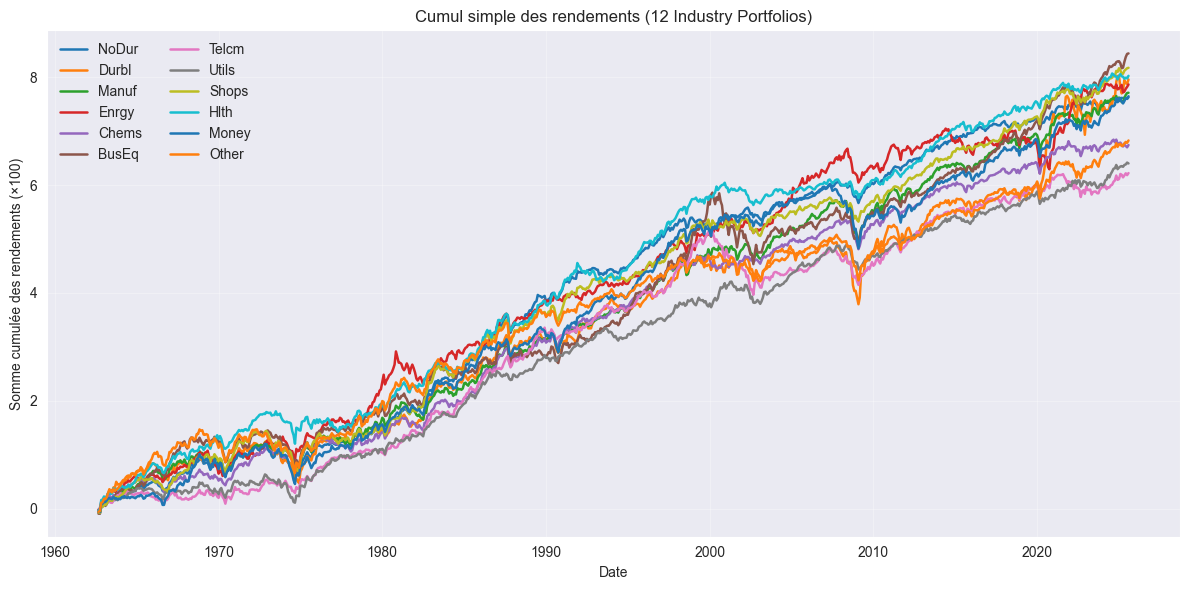

In [207]:
plt.figure(figsize=(12,6))
for c in indus_cum.columns[:12]:
    plt.plot(indus_cum.index, indus_cum[c], label=c, lw=1.8)

plt.title("Cumul simple des rendements (12 Industry Portfolios)")
plt.xlabel("Date")
plt.ylabel("Somme cumulée des rendements (×100)")
plt.legend(ncol=2, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Données facteurs

In [208]:
# Fama-French 5 + Momentum (MKT, SMB, HML, RMW, CMA, MOM)
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
ff5 = pd.read_csv(url, skiprows=3)

# Nettoyage colonnes + filtre des lignes AAAAMM
ff5 = ff5.rename(columns={ff5.columns[0]: "Date"})
ff5.columns = ff5.columns.str.strip()
ff5 = ff5[ff5["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

ff5["Date"] = pd.to_datetime(ff5["Date"], format="%Y%m")
ff5 = ff5.set_index("Date")
ff5  = ff5.astype(float) / 100

# --- MOM (Momentum) ---
url_mom = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
mom = pd.read_csv(url_mom, skiprows=13)

# Nettoyage noms de colonnes et de la colonne Date
mom = mom.rename(columns={mom.columns[0]: "Date"})
mom.columns = mom.columns.str.strip()

# Garder uniquement les lignes AAAAMM (et ignorer les NaN dans le masque)
mom = mom[mom["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

# Index temps + numérisation
mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m")
# Convertir toutes les colonnes en float, puis en proportions
mom = mom.set_index("Date")
mom = mom.apply(pd.to_numeric, errors="coerce") / 100

# Renommer proprement la colonne momentum (souvent "Mom" avec espaces)
mom.columns = mom.columns.str.strip()
mom = mom.rename(columns={mom.columns[0]: "MOM"})  # sécurise quel que soit l'intitulé

# --- Merge ---
ff_factors = ff5.join(mom[["MOM"]], how="inner")
print(ff_factors.tail())

            Mkt-RF     SMB     HML     RMW     CMA      RF     MOM
Date                                                              
2025-05-01  0.0606 -0.0072 -0.0288  0.0129  0.0251  0.0038  0.0221
2025-06-01  0.0486 -0.0002 -0.0160 -0.0320  0.0145  0.0034 -0.0264
2025-07-01  0.0198 -0.0015 -0.0127 -0.0029 -0.0208  0.0034 -0.0096
2025-08-01  0.0185  0.0488  0.0442 -0.0068  0.0207  0.0038 -0.0354
2025-09-01  0.0339 -0.0218 -0.0105 -0.0203 -0.0222  0.0033  0.0466


In [209]:

# # 1️⃣ Créer le marché total (ETF-like)
# ff_factors["MKT"] = ff_factors["Mkt-RF"] + ff_factors["RF"]

# # # 2️⃣ Sélectionner les colonnes de facteurs à tracer
# # factor_cols = ["MKT", "SMB", "HML", "RMW", "CMA", "MOM"]

# # 3️⃣ Sous-échantillon à partir de 2016
# ff_sub = ff_factors.loc["1999-01-01":, :]

# # 4️⃣ Calculer les performances cumulées
# ff_cum = (1 + ff_sub).cumprod() - 1

# # 5️⃣ Plot
# plt.figure(figsize=(12,6))
# palette = sns.color_palette("tab10", n_colors=len(factor_cols))

# for i, col in enumerate(factor_cols):
#     plt.plot(ff_cum.index, ff_cum[col], label=col, lw=2, color=palette[i])

# plt.title("Performance cumulée des facteurs Fama–French + MOM (depuis 2016)",
#           fontsize=13, weight="bold")
# plt.xlabel("Date")
# plt.ylabel("Rendement cumulé")
# plt.grid(alpha=0.3)
# plt.legend(frameon=False, ncol=3)
# plt.tight_layout()
# plt.show()

## Unsupervised

Composantes retenues : 29
Variance expliquée cumulée : 80.81%


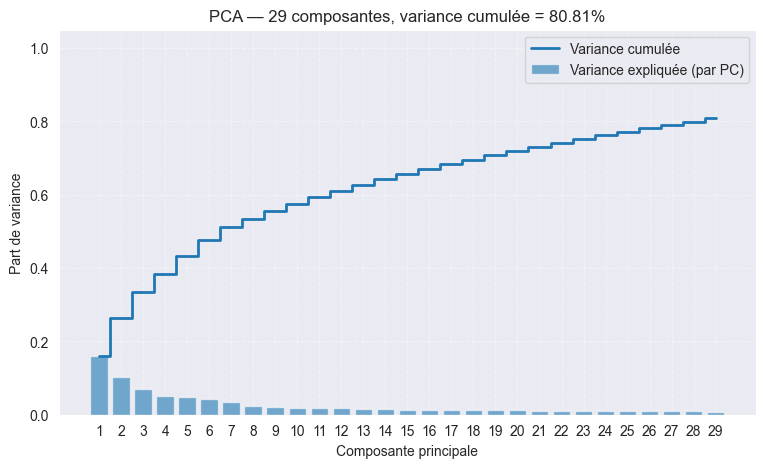

In [210]:
# ============================================
# PCA (fit sur TRAIN) puis projection du TEST
# ============================================

# Hypothèses :
# - train_std et test_std existent déjà (standardisés AVEC LE MÊME scaler : fit sur train, transform sur test)

pca = PCA(n_components=0.80, svd_solver='full')

# --- Fit sur TRAIN ---
X_pca_train = pd.DataFrame(
    pca.fit_transform(train_std),
    index=train_std.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print(f"Composantes retenues : {pca.n_components_}")
print(f"Variance expliquée cumulée : {pca.explained_variance_ratio_.sum():.2%}")

# --- Transform du TEST (projection OOS dans l'espace PCA IS) ---
X_pca_test = pd.DataFrame(
    pca.transform(test_std),
    index=test_std.index,
    columns=X_pca_train.columns
)

# (optionnel) concat pour avoir toute la série dans le même repère PCA
X_pca_all = pd.concat([X_pca_train, X_pca_test]).sort_index()

# ============================================
# Plot variance expliquée (sur train)
# ============================================

evr = pca.explained_variance_ratio_
evr_cum = np.cumsum(evr)
k = pca.n_components_

plt.figure(figsize=(9, 5))
plt.bar(np.arange(1, k+1), evr, alpha=0.6, label='Variance expliquée (par PC)')
plt.step(np.arange(1, k+1), evr_cum, where='mid', linewidth=2.0, label='Variance cumulée')

plt.xlabel('Composante principale')
plt.ylabel('Part de variance')
plt.title(f'PCA — {k} composantes, variance cumulée = {evr_cum[-1]:.2%}')
plt.xticks(np.arange(1, k+1, max(1, k//20)))
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()
plt.close()



=== Critères par k (TRAIN) ===
      loglik           AIC           BIC         ENT           ICL
k                                                                 
5 -50.571124  65419.002600  66731.133261  -95.073162  66921.279584
6 -50.265425  65145.335795  66720.785193 -104.038635  66928.862463
3 -51.267393  66076.737594  66862.230778  -40.172417  66942.575612
4 -50.907103  65732.768169  66781.580091  -92.852366  66967.284823
7 -50.087811  65035.920355  66874.688491  -86.667524  67048.023539
2 -51.762020  66592.610486  67114.784933  -39.128694  67193.042320
8 -49.933234  64955.958446  67058.045320  -96.302431  67250.650183
9 -49.827605  64938.315899  67303.721511  -96.373653  67496.468818


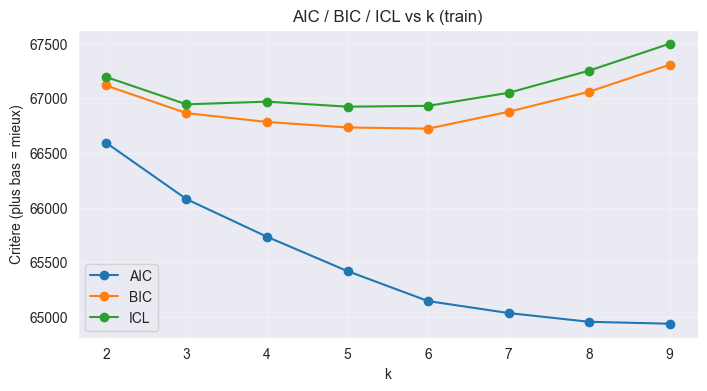

In [211]:
# === 1) Calcule et affiche les critères pour k in [2..5] ===
k_candidates = range(2, 10)
rows = []
models = {}

for k_ in k_candidates:
    g = GaussianMixture(
        n_components=k_,
        covariance_type="diag",
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(X_pca_train)

    bic = g.bic(X_pca_train)
    aic = g.aic(X_pca_train)
    tau = np.clip(g.predict_proba(X_pca_train), 1e-12, 1.0)
    ent = (tau * np.log(tau)).sum()          # ENT <= 0
    icl = bic - 2.0 * ent                    # ICL à minimiser

    rows.append({"k": k_, "loglik": g.lower_bound_, "AIC": aic, "BIC": bic, "ENT": ent, "ICL": icl})
    models[k_] = g

ic_df = pd.DataFrame(rows).set_index("k")
print("\n=== Critères par k (TRAIN) ===")
print(ic_df.sort_values("ICL"))

# (optionnel) petit plot pour t’aider à choisir
plt.figure(figsize=(8,4))
for col in ["AIC","BIC","ICL"]:
    plt.plot(ic_df.index, ic_df[col], marker='o', label=col)
plt.xlabel("k"); plt.ylabel("Critère (plus bas = mieux)")
plt.title("AIC / BIC / ICL vs k (train)")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# === 2) Choix manuel du nombre de régimes ===
chosen_k = 6  # <-- mets la valeur que TU veux
gmm = models[chosen_k]

# Sécurité : si tu préfères refitter proprement (mêmes hyperparams) :
# gmm = GaussianMixture(n_components=chosen_k, covariance_type="diag",
#                       n_init=10, reg_covar=1e-6, random_state=42).fit(X_pca_train)

if hasattr(gmm, "converged_") and not gmm.converged_:
    print("GMM non convergé.")

# === 3) Prédictions (train) ===
labels_tr = gmm.predict(X_pca_train)
probas_tr = gmm.predict_proba(X_pca_train)
llk_tr    = gmm.score_samples(X_pca_train)

# construit la série indexée pour tes plots
dates_train = X_pca_train.index
gmm_labels = pd.Series(labels_tr, index=dates_train, name="gmm_label").astype(int)



=== Critères par k (TRAIN) ===
      loglik           AIC           BIC         ENT           ICL
k                                                                 
5 -50.571124  65419.002600  66731.133261  -95.073162  66921.279584
6 -50.265425  65145.335795  66720.785193 -104.038635  66928.862463
3 -51.267393  66076.737594  66862.230778  -40.172417  66942.575612
4 -50.907103  65732.768169  66781.580091  -92.852366  66967.284823
7 -50.087811  65035.920355  66874.688491  -86.667524  67048.023539
2 -51.762020  66592.610486  67114.784933  -39.128694  67193.042320
8 -49.933234  64955.958446  67058.045320  -96.302431  67250.650183
9 -49.827605  64938.315899  67303.721511  -96.373653  67496.468818


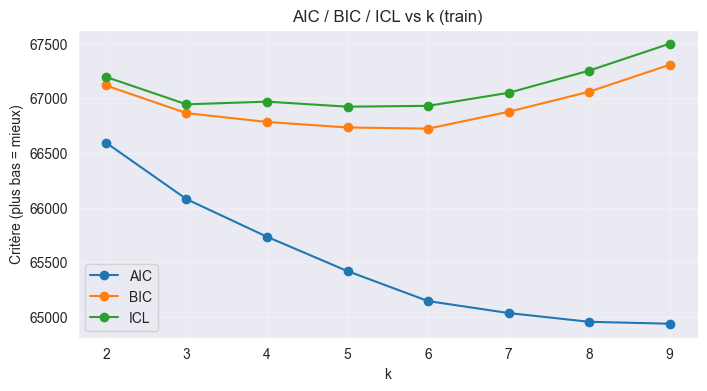

In [212]:
# === 1) Calcule et affiche les critères pour k in [2..5] ===
k_candidates = range(2, 10)
rows = []
models = {}

for k_ in k_candidates:
    g = GaussianMixture(
        n_components=k_,
        covariance_type="diag",
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(X_pca_train)

    bic = g.bic(X_pca_train)
    aic = g.aic(X_pca_train)
    tau = np.clip(g.predict_proba(X_pca_train), 1e-12, 1.0)
    ent = (tau * np.log(tau)).sum()          # ENT <= 0
    icl = bic - 2.0 * ent                    # ICL à minimiser

    rows.append({"k": k_, "loglik": g.lower_bound_, "AIC": aic, "BIC": bic, "ENT": ent, "ICL": icl})
    models[k_] = g

ic_df = pd.DataFrame(rows).set_index("k")
print("\n=== Critères par k (TRAIN) ===")
print(ic_df.sort_values("ICL"))

# (optionnel) petit plot pour t’aider à choisir
plt.figure(figsize=(8,4))
for col in ["AIC","BIC","ICL"]:
    plt.plot(ic_df.index, ic_df[col], marker='o', label=col)
plt.xlabel("k"); plt.ylabel("Critère (plus bas = mieux)")
plt.title("AIC / BIC / ICL vs k (train)")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# === 2) Choix manuel du nombre de régimes ===
chosen_k = 6  # <-- mets la valeur que TU veux
gmm = models[chosen_k]

# Sécurité : si tu préfères refitter proprement (mêmes hyperparams) :
# gmm = GaussianMixture(n_components=chosen_k, covariance_type="diag",
#                       n_init=10, reg_covar=1e-6, random_state=42).fit(X_pca_train)

if hasattr(gmm, "converged_") and not gmm.converged_:
    print("GMM non convergé.")

# === 3) Prédictions (train) ===
labels_tr = gmm.predict(X_pca_train)
probas_tr = gmm.predict_proba(X_pca_train)
llk_tr    = gmm.score_samples(X_pca_train)

# construit la série indexée pour tes plots
dates_train = X_pca_train.index
gmm_labels = pd.Series(labels_tr, index=dates_train, name="gmm_label").astype(int)


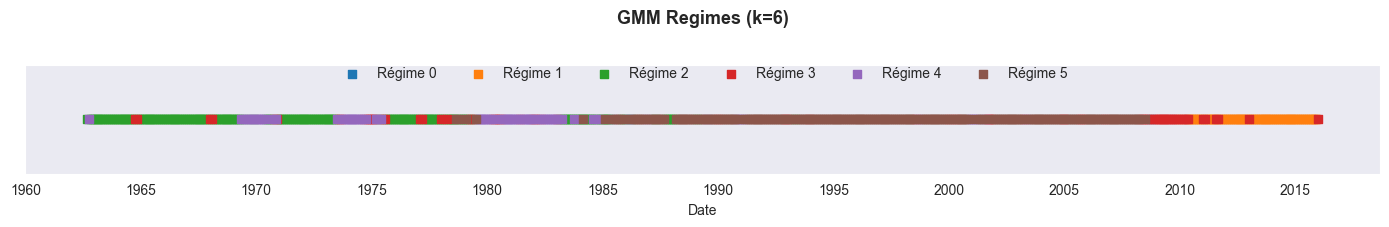

In [213]:
# --- Données : extraire les labels et l'index temps ---
dates = gmm_labels.index

# --- Palette cohérente ---
n_regimes = gmm_labels.max() + 1
palette = sns.color_palette("tab10", n_colors=n_regimes)

# --- Figure principale ---
fig, ax = plt.subplots(figsize=(14, 2.5))
ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold")

# Plot des points colorés (timeline horizontale)
for k_ in range(n_regimes):
    idx_k = gmm_labels[gmm_labels == k_].index
    ax.scatter(idx_k, [0]*len(idx_k), s=30, color=palette[k_], label=f"Régime {k_}", marker="s")


# Mise en forme
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

# Légende centrée
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=n_regimes,
    frameon=False
)

ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold", pad=30)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10), ncol=n_regimes, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [214]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ======================================================
# 1. Évaluation sur le jeu d'entraînement
# ======================================================

# Log-likelihood global
loglik_train = gmm.score(X_pca_train) * len(X_pca_train)
aic = gmm.aic(X_pca_train)
bic = gmm.bic(X_pca_train)

# Probabilités d’appartenance
tau = gmm.predict_proba(X_pca_train)

# Entropie moyenne
entropy_mean = -(tau * np.log(tau + 1e-12)).sum(axis=1).mean()

# Pureté moyenne
purity_mean = np.mean(tau.max(axis=1))

print("\n=== Qualité du GMM (Train) ===")
print(f"Log-likelihood total : {loglik_train:,.2f}")
print(f"AIC : {aic:,.2f}")
print(f"BIC : {bic:,.2f}")
print(f"Entropie moyenne : {entropy_mean:.4f}")
print(f"Pureté moyenne   : {purity_mean:.4f}")

# ======================================================
# 2. Évaluation sur le jeu de test (si disponible)
# ======================================================

try:
    loglik_test = gmm.score(X_pca_test) * len(X_pca_test)
    tau_test = gmm.predict_proba(X_pca_test)
    entropy_test = -(tau_test * np.log(tau_test + 1e-12)).sum(axis=1).mean()
    purity_test = np.mean(tau_test.max(axis=1))

    print("\n=== Généralisation (Test) ===")
    print(f"Log-likelihood total (test) : {loglik_test:,.2f}")
    print(f"Entropie moyenne (test) : {entropy_test:.4f}")
    print(f"Pureté moyenne (test)   : {purity_test:.4f}")
    print(f"Δ LogLik (test - train) : {loglik_test - loglik_train:,.2f}")

except Exception as e:
    print("\n(Aucun jeu de test détecté ou erreur lors de l’évaluation)")
    print(e)

# ======================================================
# 3. Stabilité temporelle / structurelle (optionnel)
# ======================================================

# Exemple : comparer les régimes sur 2 sous-périodes du train
split = len(X_pca_train) // 2
idx_1 = X_pca_train.index[:split]
idx_2 = X_pca_train.index[split:]

gmm_1 = GaussianMixture(
    n_components=chosen_k, covariance_type="diag",
    n_init=10, reg_covar=1e-6, random_state=42
).fit(X_pca_train.loc[idx_1])

labels_1 = gmm_1.predict(X_pca_train.loc[idx_1])
labels_2 = gmm.predict(X_pca_train.loc[idx_2])

# Comparaison des régimes entre les deux périodes
ari = adjusted_rand_score(labels_1[-len(labels_2):], labels_2)
nmi = normalized_mutual_info_score(labels_1[-len(labels_2):], labels_2)

print("\n=== Stabilité des régimes ===")
print(f"Adjusted Rand Index (ARI) : {ari:.3f}")
print(f"Normalized Mutual Info (NMI) : {nmi:.3f}")

# ======================================================
# 4. Synthèse rapide
# ======================================================

summary = pd.DataFrame({
    "Metric": ["LogLik_train", "AIC", "BIC", "Entropy", "Purity"],
    "Value": [loglik_train, aic, bic, entropy_mean, purity_mean]
})
print("\n=== Résumé synthétique ===")
display(summary)



=== Qualité du GMM (Train) ===
Log-likelihood total : -32,219.67
AIC : 65,145.34
BIC : 66,720.79
Entropie moyenne : 0.1623
Pureté moyenne   : 0.9417

=== Généralisation (Test) ===
Log-likelihood total (test) : -11,051.11
Entropie moyenne (test) : 0.3118
Pureté moyenne (test)   : 0.8780
Δ LogLik (test - train) : 21,168.56


ValueError: Found input variables with inconsistent numbers of samples: [320, 321]


=== Critères par k (TRAIN bis) ===
      loglik           AIC           BIC        ENT           ICL
k                                                                
7 -23.882129  31356.789885  33008.110784 -21.824629  33051.760042
6 -25.297578  33065.057262  34479.837600 -32.164025  34544.165649
5 -25.912613  33747.932659  34926.172436 -19.280365  34964.733166
4 -26.806625  34788.055143  35729.754358 -18.802715  35767.359788
3 -28.584314  36960.496408  37665.655062 -33.791424  37733.237910
2 -30.550736  39375.887141  39844.505234  -4.207036  39852.919305


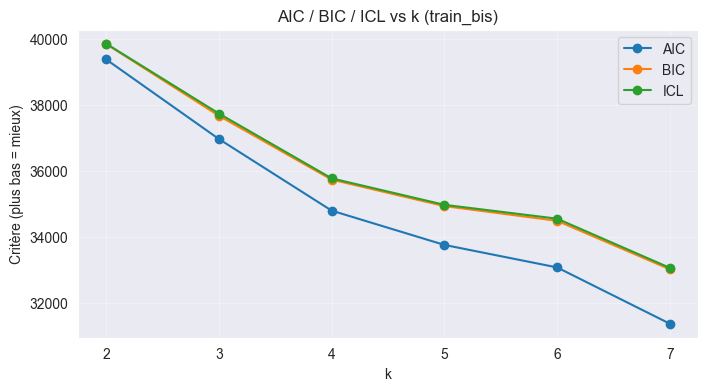


Extrait (train):
            p_regime_1    p_regime_2    p_regime_3    p_regime_4  \
sasdate                                                            
1962-09-01    1.000000  1.330476e-08  1.019124e-23  6.620272e-08   
1962-10-01    0.999994  1.700380e-09  6.639372e-23  5.930909e-06   
1962-11-01    0.999998  2.946251e-10  1.018261e-26  1.793976e-06   
1962-12-01    1.000000  5.474357e-10  6.935756e-26  3.149066e-07   
1963-01-01    0.999990  3.320375e-10  5.569676e-24  1.034077e-05   

              p_regime_5     loglik  regime  
sasdate                                      
1962-09-01  4.010685e-42 -17.136182       1  
1962-10-01  3.446989e-43 -20.939399       1  
1962-11-01  1.979678e-52 -22.506928       1  
1962-12-01  5.585909e-46 -21.554997       1  
1963-01-01  1.763596e-46 -24.737982       1  

Extrait (test):
            p_regime_1  p_regime_2    p_regime_3  p_regime_4  p_regime_5  \
sasdate                                                                    
2016-01-01    

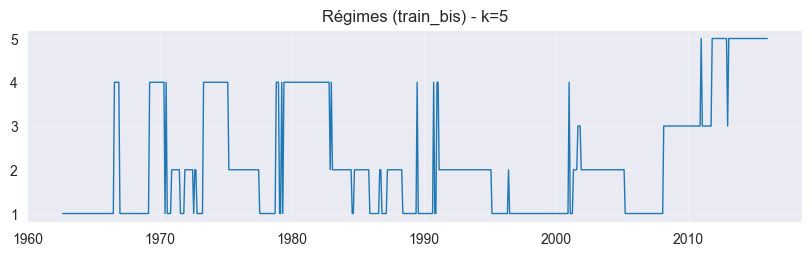

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# ----------------------------
# 0) Données d'entrée (bis)
# ----------------------------
# Hypothèses : train_std_bis, test_std_bis existent déjà (DataFrames normalisés)
X_bis_train = train_std_bis.copy()
X_bis_test  = test_std_bis.copy()

# (sécurité) enlève colonnes 100% NaN s'il y en a
keep_cols = X_bis_train.columns[X_bis_train.notna().any()]
X_bis_train = X_bis_train[keep_cols]
X_bis_test  = X_bis_test.reindex(columns=keep_cols)

# ----------------------------
# 1) Critères AIC/BIC/ICL pour k=2..9
# ----------------------------
k_candidates = range(2, 8)
rows = []
models = {}

for k_ in k_candidates:
    g = GaussianMixture(
        n_components=k_,
        covariance_type="diag",
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(X_bis_train)

    bic = g.bic(X_bis_train)
    aic = g.aic(X_bis_train)
    tau = np.clip(g.predict_proba(X_bis_train), 1e-12, 1.0)
    ent = (tau * np.log(tau)).sum()         # <= 0
    icl = bic - 2.0 * ent                   # ICL à minimiser

    rows.append({
        "k": k_,
        "loglik": g.lower_bound_,
        "AIC": aic, "BIC": bic, "ENT": ent, "ICL": icl
    })
    models[k_] = g

ic_df = pd.DataFrame(rows).set_index("k")
print("\n=== Critères par k (TRAIN bis) ===")
print(ic_df.sort_values("ICL"))

# (optionnel) visu
plt.figure(figsize=(8,4))
for col in ["AIC","BIC","ICL"]:
    plt.plot(ic_df.index, ic_df[col], marker='o', label=col)
plt.xlabel("k"); plt.ylabel("Critère (plus bas = mieux)")
plt.title("AIC / BIC / ICL vs k (train_bis)")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# ----------------------------
# 2) Choix du nombre de régimes
# ----------------------------
# Option auto : décommente pour choisir k minimisant l'ICL
# chosen_k = ic_df["ICL"].idxmin()

# Ou fixe-le manuellement
chosen_k = 5

gmm = models[chosen_k]
if hasattr(gmm, "converged_") and not gmm.converged_:
    print("GMM non convergé.")

# ----------------------------
# 3) Prédictions train/test (bis)
# ----------------------------
labels_tr = gmm.predict(X_bis_train)         # 0..k-1
probas_tr = gmm.predict_proba(X_bis_train)
llk_tr    = gmm.score_samples(X_bis_train)

labels_te = gmm.predict(X_bis_test)
probas_te = gmm.predict_proba(X_bis_test)
llk_te    = gmm.score_samples(X_bis_test)

# ----------------------------
# 4) Séries indexées + régimes commençant à 1
# ----------------------------
gmm_labels_train = pd.Series(labels_tr + 1, index=X_bis_train.index,
                             name="regime").astype(int)
gmm_labels_test  = pd.Series(labels_te + 1, index=X_bis_test.index,
                             name="regime").astype(int)

# (facultatif) DataFrames de diagnostic
gmm_diag_train = pd.DataFrame(
    probas_tr, index=X_bis_train.index,
    columns=[f"p_regime_{i+1}" for i in range(chosen_k)]
).assign(loglik=llk_tr, regime=gmm_labels_train)

gmm_diag_test = pd.DataFrame(
    probas_te, index=X_bis_test.index,
    columns=[f"p_regime_{i+1}" for i in range(chosen_k)]
).assign(loglik=llk_te, regime=gmm_labels_test)

print("\nExtrait (train):")
print(gmm_diag_train.head())
print("\nExtrait (test):")
print(gmm_diag_test.head())

# ----------------------------
# 5) (optionnel) petite visu des régimes
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(gmm_labels_train.index, gmm_labels_train.values, lw=1)
ax.set_title(f"Régimes (train_bis) - k={chosen_k}")
ax.set_yticks(range(1, chosen_k+1))
ax.grid(alpha=0.3)
plt.show()


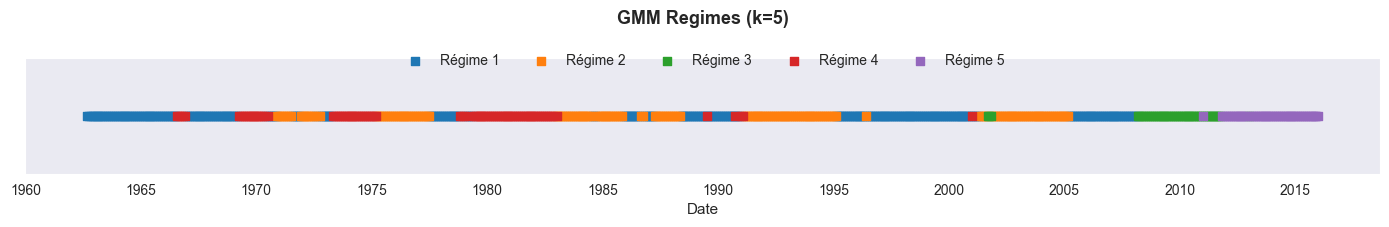

In [216]:
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

# --- Données : labels et index temps ---
dates = gmm_labels_train.index
labels = gmm_labels_train

# --- Palette cohérente (commence à 1) ---
n_regimes = labels.max()
palette = sns.color_palette("tab10", n_colors=n_regimes)

# --- Figure principale ---
fig, ax = plt.subplots(figsize=(14, 2.5))

for k_ in range(1, n_regimes + 1):
    idx_k = labels[labels == k_].index
    ax.scatter(idx_k, [0]*len(idx_k), s=30, color=palette[k_-1],
               label=f"Régime {k_}", marker="s")

# --- Mise en forme ---
ax.set_yticks([])
ax.set_xlabel("Date", fontsize=11)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold", pad=25)

# --- Légende centrée et propre ---
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [217]:
# --- Entropie et pureté ---
tau = gmm.predict_proba(X_bis_train)
entropy = -(tau * np.log(tau + 1e-12)).sum(axis=1).mean()
purity = np.mean(tau.max(axis=1))
print(f"Entropie moyenne: {entropy:.4f}")
print(f"Pureté moyenne:   {purity:.4f}")

Entropie moyenne: 0.0301
Pureté moyenne:   0.9892



=== Métriques K-Means (TRAIN bis) ===
        inertia  silhouette  calinski_harabasz  davies_bouldin
k                                                             
2  14591.688627    0.132999          90.838353        2.460135
3  13015.586454    0.149432          89.468264        2.092395
4  12285.872840    0.098990          75.700523        2.335588
5  11685.101331    0.104162          67.775440        2.237134
6  11351.606443    0.096507          59.456605        2.235097
7  11057.164223    0.094210          53.600269        2.232118


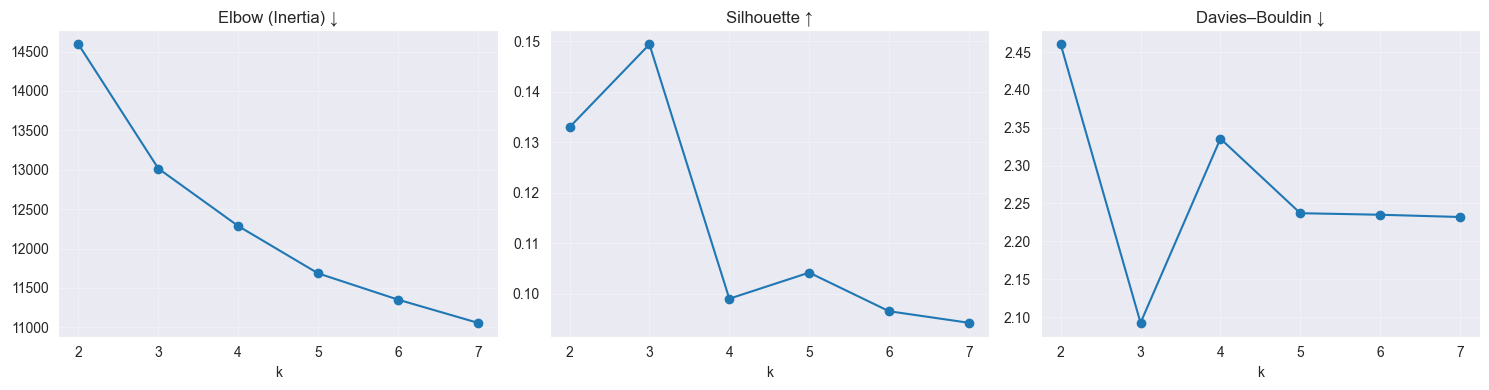


Choix final k = 3

Distribution des régimes (train) :
1    172
2    373
3     96
Name: regime, dtype: int64

Confiance (ratio d1/d2) — plus petit = assignation plus nette :
count    641.000000
mean       0.742498
std        0.142365
min        0.354016
25%        0.631900
50%        0.758003
75%        0.854922
max        0.994989
Name: margin, dtype: float64


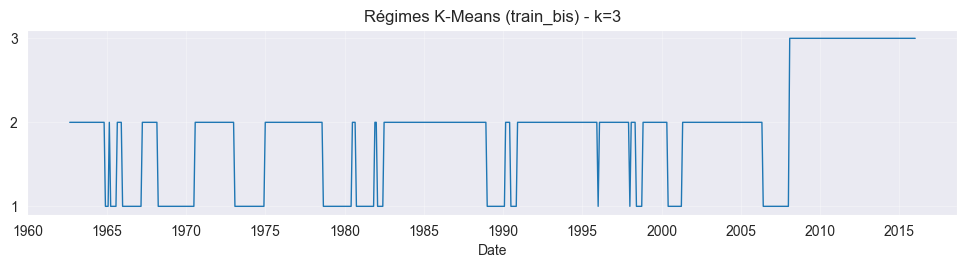

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# ----------------------------
# 0) Données d'entrée (bis)
# ----------------------------
# Hypothèse : train_std_bis, test_std_bis existent (DataFrames normalisés)
X_bis_train = train_std_bis.copy()
X_bis_test  = test_std_bis.copy()

# (sécurité) enlève colonnes 100% NaN s'il y en a
keep_cols = X_bis_train.columns[X_bis_train.notna().any()]
X_bis_train = X_bis_train[keep_cols]
X_bis_test  = X_bis_test.reindex(columns=keep_cols)

# ----------------------------
# 1) Grid search de k : métriques K-Means
# ----------------------------
k_candidates = range(2, 8)
rows = []
models = {}

for k_ in k_candidates:
    km = KMeans(
        n_clusters=k_,
        n_init=20,
        max_iter=500,
        random_state=42
    ).fit(X_bis_train)

    labels_tr = km.labels_
    inertia   = km.inertia_  # somme des distances au centre (within-cluster SSE)

    # certaines métriques nécessitent au moins 2 clusters et n_samples > k
    if len(X_bis_train) > k_:
        sil = silhouette_score(X_bis_train, labels_tr)
        ch  = calinski_harabasz_score(X_bis_train, labels_tr)
        db  = davies_bouldin_score(X_bis_train, labels_tr)
    else:
        sil, ch, db = np.nan, np.nan, np.nan

    rows.append({
        "k": k_,
        "inertia": inertia,       # à minimiser (elbow)
        "silhouette": sil,        # à maximiser
        "calinski_harabasz": ch,  # à maximiser
        "davies_bouldin": db      # à minimiser
    })
    models[k_] = km

km_df = pd.DataFrame(rows).set_index("k")
print("\n=== Métriques K-Means (TRAIN bis) ===")
print(km_df)

# (optionnel) visu des critères
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(km_df.index, km_df["inertia"], marker='o'); ax[0].set_title("Elbow (Inertia) ↓"); ax[0].set_xlabel("k"); ax[0].grid(alpha=0.3)
ax[1].plot(km_df.index, km_df["silhouette"], marker='o'); ax[1].set_title("Silhouette ↑"); ax[1].set_xlabel("k"); ax[1].grid(alpha=0.3)
ax[2].plot(km_df.index, km_df["davies_bouldin"], marker='o'); ax[2].set_title("Davies–Bouldin ↓"); ax[2].set_xlabel("k"); ax[2].grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ----------------------------
# 2) Choix du nombre de régimes
# ----------------------------
# Option auto (choix par silhouette, fallback DBI)
try:
    chosen_k = km_df["silhouette"].idxmax()
except Exception:
    chosen_k = km_df["davies_bouldin"].idxmin()

# Ou fixe-le manuellement :
# chosen_k = 5

kmeans = models[chosen_k]

# ----------------------------
# 3) Prédictions train/test (bis)
# ----------------------------
labels_tr = kmeans.predict(X_bis_train)   # 0..k-1
labels_te = kmeans.predict(X_bis_test)

# ----------------------------
# 4) Séries indexées + régimes commençant à 1
# ----------------------------
km_labels_train = pd.Series(labels_tr + 1, index=X_bis_train.index,
                            name="regime").astype(int)
km_labels_test  = pd.Series(labels_te + 1, index=X_bis_test.index,
                            name="regime").astype(int)

print(f"\nChoix final k = {chosen_k}")
print("\nDistribution des régimes (train) :")
print(km_labels_train.value_counts().sort_index())

# ----------------------------
# 5) (optionnel) "confiance" d’assignation
#    ratio = d1 / d2 avec d1 = distance au centre le plus proche,
#    d2 = distance au 2e plus proche (plus petit = plus net)
# ----------------------------
def assignment_margin(X, km):
    # distances aux centres (n_samples x k)
    # scikit-learn >=1.4 : km.transform(X) donne distances euclidiennes
    D = kmeans.transform(X)
    d_sorted = np.sort(D, axis=1)
    return (d_sorted[:, 0] / (d_sorted[:, 1] + 1e-12))

margin_train = pd.Series(assignment_margin(X_bis_train, kmeans),
                         index=X_bis_train.index, name="margin")
print("\nConfiance (ratio d1/d2) — plus petit = assignation plus nette :")
print(margin_train.describe())

# ----------------------------
# 6) (optionnel) timeline des régimes (train)
# ----------------------------
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 2.4))
ax.plot(km_labels_train.index, km_labels_train.values, lw=1)
ax.set_title(f"Régimes K-Means (train_bis) - k={chosen_k}")
ax.set_yticks(range(1, chosen_k+1))
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(alpha=0.3)
plt.show()


Étape 1 : Détection des outliers via One-Class SVM (sur PCA)...
Outliers détectés (OCSVM) : 68 sur 641 observations (10.6%).
Étape 2 : K-means cosinus sur les mois typiques (PCA)...


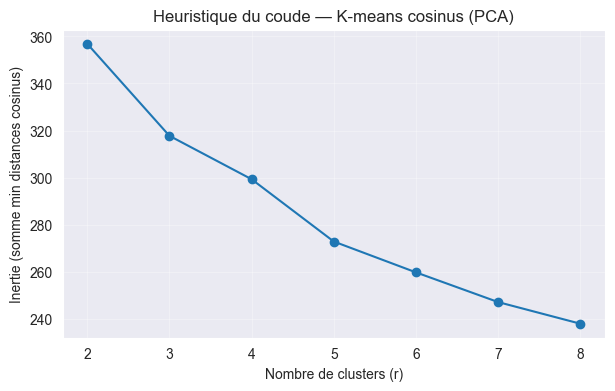

Nombre de régimes réguliers retenu : r = 5
Clustering cosinus terminé.
Étape 3 : Calcul des distributions de probabilité...
Étape 4 : Calcul de la matrice de transition...
Matrice de transition P(i→j) :
       0      1      2      3      4      5
0  0.463  0.090  0.060  0.075  0.179  0.134
1  0.077  0.846  0.000  0.067  0.010  0.000
2  0.030  0.000  0.597  0.015  0.090  0.269
3  0.028  0.056  0.000  0.838  0.070  0.007
4  0.155  0.021  0.052  0.093  0.546  0.134
5  0.049  0.000  0.110  0.006  0.092  0.742


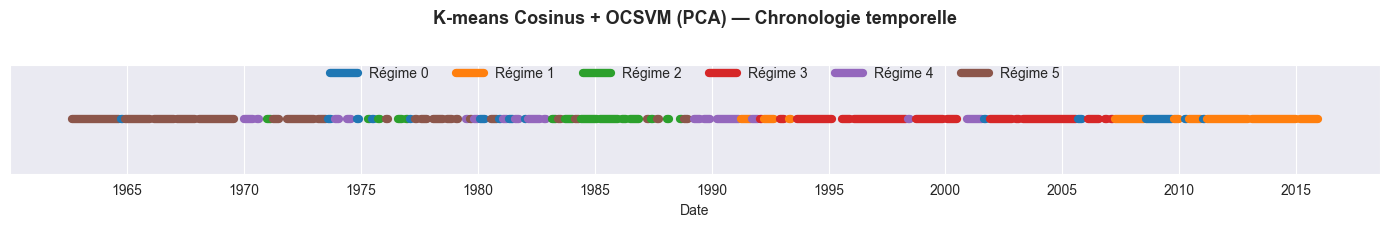

In [219]:
# ============================================
# K-MEANS REGIME DETECTION — VERSION PCA + OCSVM (FIDÈLE AUTEURS)
# ============================================

# ----------------------------------------------------
# 1. Détection des outliers via One-Class SVM
# ----------------------------------------------------
print("Étape 1 : Détection des outliers via One-Class SVM (sur PCA)...")

# ν = fraction maximale d'outliers (ex: 0.02 = 2%)
ocs = OneClassSVM(kernel="rbf", nu=0.1, gamma="scale").fit(X_pca_train)
is_outlier = ocs.predict(X_pca_train) == -1
decision_scores = ocs.decision_function(X_pca_train)  # plus petit = plus anormal

# Convertir scores en probabilité approchée (sigmoïde)
from scipy.special import expit
p_reg0 = 1 - expit((decision_scores - np.min(decision_scores)) / (np.std(decision_scores) + 1e-8))

X_typical = X_pca_train.loc[~is_outlier]
dates_typical = X_typical.index
print(f"Outliers détectés (OCSVM) : {is_outlier.sum()} sur {len(X_pca_train)} observations ({100*is_outlier.mean():.1f}%).")

# ----------------------------------------------------
# 2. Vrai K-means Cosinus sur les mois typiques
# ----------------------------------------------------
print("Étape 2 : K-means cosinus sur les mois typiques (PCA)...")

def spherical_kmeans(X, k, max_iter=300, tol=1e-6, random_state=42):
    rng = np.random.default_rng(random_state)
    X = normalize(X, norm='l2')  # chaque observation sur la sphère unité
    n, d = X.shape

    centers = X[rng.choice(n, k, replace=False)]
    centers = normalize(centers, norm='l2')

    for it in range(max_iter):
        sim = X @ centers.T
        labels = np.argmax(sim, axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                new_centers[j] = normalize(cluster_points.mean(axis=0).reshape(1, -1))
            else:
                new_centers[j] = centers[j]
        diff = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if diff < tol:
            break
    dist_cos = 1 - (X @ centers.T)
    return labels, centers, dist_cos

# --- Détermination du nombre optimal r
inertias = []
k_range = range(2, 9)
X_typical_np = X_typical.values
for k_ in k_range:
    labels, centers, dist_cos = spherical_kmeans(X_typical_np, k_)
    inertia = np.sum(np.min(dist_cos, axis=1))
    inertias.append(inertia)

plt.figure(figsize=(7, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Heuristique du coude — K-means cosinus (PCA)")
plt.xlabel("Nombre de clusters (r)")
plt.ylabel("Inertie (somme min distances cosinus)")
plt.grid(True, alpha=0.3)
plt.show()

r = 5  # ajuster selon le coude
print(f"Nombre de régimes réguliers retenu : r = {r}")

cos_labels, cos_centers, cos_dists = spherical_kmeans(X_typical_np, r)
print("Clustering cosinus terminé.")

# ----------------------------------------------------
# 3. Distributions de probabilité (Éqs. 1 et 4)
# ----------------------------------------------------
print("Étape 3 : Calcul des distributions de probabilité...")

cos_probs = 1 - (cos_dists / cos_dists.sum(axis=1, keepdims=True))
cos_probs = cos_probs / cos_probs.sum(axis=1, keepdims=True)

final_probs = pd.DataFrame(index=dates, columns=[f"Regime_{i}" for i in range(r+1)], dtype=float)
final_probs.loc[:, :] = 0.0

Pm = np.max(cos_probs, axis=1)
P0 = p_reg0[~is_outlier]

# Éq. (4) : P_R0 = - Pm * log2(1 - P(Regime 0))
PR0 = -Pm * np.log2(1 - P0)
PR0[np.isnan(PR0)] = 0.0
PR0[PR0 < 0] = 0.0

final_probs.loc[dates_typical, "Regime_0"] = PR0
for j in range(r):
    final_probs.loc[dates_typical, f"Regime_{j+1}"] = cos_probs[:, j]

final_probs.loc[dates[is_outlier], "Regime_0"] = 1.0
final_probs = final_probs.div(final_probs.sum(axis=1), axis=0)

hard_labels = final_probs.idxmax(axis=1).str.extract("(\d+)").astype(int).values.flatten()

# ----------------------------------------------------
# 4. Matrice de transition (Éq. 5)
# ----------------------------------------------------
print("Étape 4 : Calcul de la matrice de transition...")

ordered_labels = pd.Series(hard_labels, index=dates).sort_index()
regimes = np.unique(hard_labels)
transition_matrix = pd.DataFrame(0.0, index=regimes, columns=regimes)

for i in range(len(ordered_labels)-1):
    i_reg = ordered_labels.iloc[i]
    j_reg = ordered_labels.iloc[i+1]
    transition_matrix.loc[i_reg, j_reg] += 1

transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
print("Matrice de transition P(i→j) :")
print(transition_matrix.round(3))

# ----------------------------------------------------
# 5. Visualisation temporelle
# ----------------------------------------------------
# --- Nettoyage et paramétrage ---
res_kmeans = pd.DataFrame({"kmeans_label": hard_labels}, index=dates).sort_index()
palette = sns.color_palette("tab10", n_colors=res_kmeans["kmeans_label"].nunique())

fig, ax = plt.subplots(figsize=(14, 2.5))
ax.set_title("K-means Cosinus + OCSVM (PCA) — Chronologie temporelle", fontsize=13, weight="bold", pad=30)

# --- Construction de segments (blocs continus) ---
labels = res_kmeans["kmeans_label"].values
times = res_kmeans.index

start_idx = 0
for i in range(1, len(labels)):
    if labels[i] != labels[i-1] or i == len(labels)-1:
        ax.plot(times[start_idx:i], [0]* (i-start_idx),
                color=palette[labels[i-1]], lw=6)
        start_idx = i

# --- Mise en forme ---
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.legend(
    handles=[plt.Line2D([0], [0], color=palette[k], lw=6, label=f"Régime {k}")
             for k in sorted(res_kmeans["kmeans_label"].unique())],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=res_kmeans["kmeans_label"].nunique(),
    frameon=False
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Étape 1 : Détection des outliers via One-Class SVM (sur TRAIN)...
Outliers détectés (TRAIN) : 69 / 641 (10.8%).
Étape 2 : K-Means cosinus (sans PCA) sur les mois typiques...


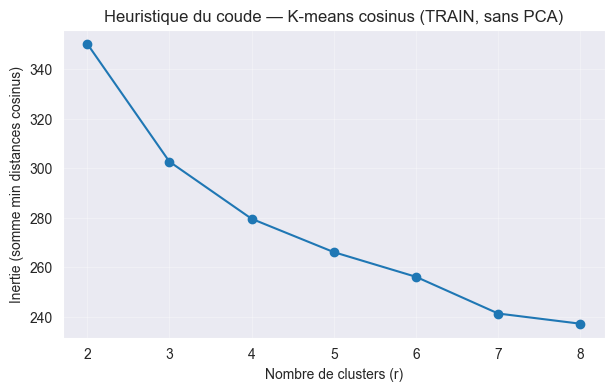

Nombre de régimes réguliers retenu : r = 5
Clustering cosinus (TRAIN) terminé.
Étape 3 : Calcul des distributions de probabilité (TRAIN)...
Étape 4 : Matrice de transition (TRAIN)...
Matrice de transition P(i→j) — TRAIN :
       0      1      2      3      4      5
0  0.412  0.221  0.044  0.162  0.118  0.044
1  0.197  0.763  0.013  0.026  0.000  0.000
2  0.024  0.024  0.835  0.012  0.035  0.071
3  0.062  0.000  0.000  0.733  0.014  0.192
4  0.074  0.007  0.007  0.007  0.797  0.108
5  0.034  0.000  0.077  0.205  0.145  0.538


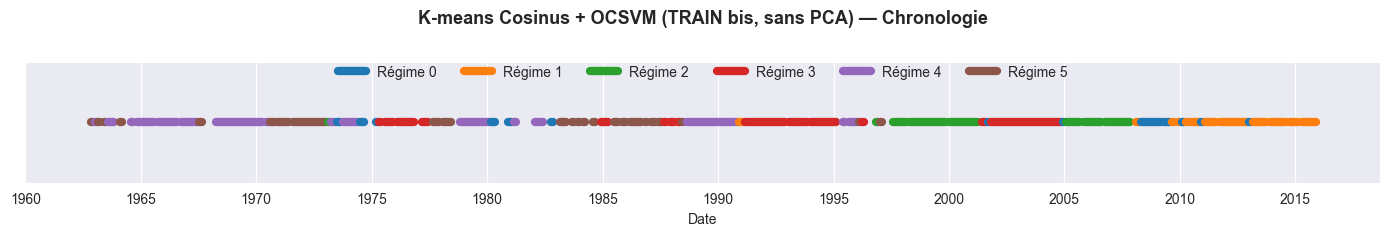

Projection sur TEST (mêmes OCSVM/centres)...
Distribution des régimes (TEST) :
0    66
1    48
2     1
Name: kmeans_label, dtype: int64


In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import normalize
from scipy.special import expit

# =========================================================
# 0) Données d'entrée (déjà normalisées avec moments du train)
# =========================================================
# Hypothèses : train_std_bis, test_std_bis existent déjà
X_tr = train_std_bis.copy()
X_te = test_std_bis.copy()

# Sécurité colonnes vides / alignement
keep_cols = X_tr.columns[X_tr.notna().any()]
X_tr = X_tr[keep_cols]
X_te = X_te.reindex(columns=keep_cols)

dates_tr = X_tr.index
dates_te = X_te.index

# =========================================================
# 1) OCSVM — détection des outliers (fit uniquement sur TRAIN)
# =========================================================
print("Étape 1 : Détection des outliers via One-Class SVM (sur TRAIN)...")

ocs = OneClassSVM(kernel="rbf", nu=0.10, gamma="scale").fit(X_tr)
is_outlier_tr = (ocs.predict(X_tr) == -1)
decision_scores_tr = ocs.decision_function(X_tr)   # plus petit = plus anormal

# Calibration heuristique proba outlier (stable train->test)
p_reg0_tr = 1 - expit((decision_scores_tr - decision_scores_tr.min()) /
                       (decision_scores_tr.std() + 1e-8))

X_typ_tr = X_tr.loc[~is_outlier_tr]
dates_typ_tr = X_typ_tr.index

print(f"Outliers détectés (TRAIN) : {is_outlier_tr.sum()} / {len(X_tr)} "
      f"({100*is_outlier_tr.mean():.1f}%).")

# =========================================================
# 2) Spherical K-Means (cosinus) sur mois typiques (TRAIN)
# =========================================================
print("Étape 2 : K-Means cosinus (sans PCA) sur les mois typiques...")

def spherical_kmeans(X, k, max_iter=300, tol=1e-6, random_state=42):
    rng = np.random.default_rng(random_state)
    Xn = normalize(X, norm='l2')   # cosinus <=> points sur la sphère
    n, d = Xn.shape

    centers = Xn[rng.choice(n, k, replace=False)]
    centers = normalize(centers, norm='l2')

    for _ in range(max_iter):
        sim = Xn @ centers.T                    # similarité cosinus
        labels = np.argmax(sim, axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            pts = Xn[labels == j]
            new_centers[j] = normalize(pts.mean(axis=0, keepdims=True)) if len(pts) else centers[j]
        diff = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if diff < tol:
            break

    dist_cos = 1 - (Xn @ centers.T)            # distance cosinus = 1 - cos
    return labels, centers, dist_cos

# Heuristique du coude pour choisir r
inertias, k_range = [], range(2, 9)
X_typ_np = X_typ_tr.values
for k_ in k_range:
    _, _, dist_cos = spherical_kmeans(X_typ_np, k_)
    inertias.append(np.sum(np.min(dist_cos, axis=1)))

plt.figure(figsize=(7, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Heuristique du coude — K-means cosinus (TRAIN, sans PCA)")
plt.xlabel("Nombre de clusters (r)")
plt.ylabel("Inertie (somme min distances cosinus)")
plt.grid(True, alpha=0.3)
plt.show()

r = 5  # <-- ajuste selon le coude
print(f"Nombre de régimes réguliers retenu : r = {r}")

cos_labels_tr, cos_centers, cos_dists_tr = spherical_kmeans(X_typ_np, r)
print("Clustering cosinus (TRAIN) terminé.")

# =========================================================
# 3) Distributions de probabilité — TRAIN
#    (Régime_0 = outliers ; Régimes 1..r = clusters cosinus)
# =========================================================
print("Étape 3 : Calcul des distributions de probabilité (TRAIN)...")

cos_probs_tr = 1 - (cos_dists_tr / cos_dists_tr.sum(axis=1, keepdims=True))
cos_probs_tr = cos_probs_tr / cos_probs_tr.sum(axis=1, keepdims=True)

final_probs_tr = pd.DataFrame(index=dates_tr, columns=[f"Regime_{i}" for i in range(r+1)], dtype=float)
final_probs_tr.loc[:, :] = 0.0

Pm_tr = np.max(cos_probs_tr, axis=1)
P0_tr = p_reg0_tr[~is_outlier_tr]

PR0_tr = -Pm_tr * np.log2(1 - P0_tr)
PR0_tr = np.nan_to_num(PR0_tr, nan=0.0)
PR0_tr[PR0_tr < 0] = 0.0

final_probs_tr.loc[dates_typ_tr, "Regime_0"] = PR0_tr
for j in range(r):
    final_probs_tr.loc[dates_typ_tr, f"Regime_{j+1}"] = cos_probs_tr[:, j]

# Outliers purs
final_probs_tr.loc[dates_tr[is_outlier_tr], "Regime_0"] = 1.0
final_probs_tr = final_probs_tr.div(final_probs_tr.sum(axis=1), axis=0)

hard_labels_tr = final_probs_tr.idxmax(axis=1).str.extract(r"(\d+)").astype(int).values.flatten()
res_kmeans_tr = pd.DataFrame({"kmeans_label": hard_labels_tr}, index=dates_tr).sort_index()

# =========================================================
# 4) Matrice de transition — TRAIN
# =========================================================
print("Étape 4 : Matrice de transition (TRAIN)...")

lbl_tr = res_kmeans_tr["kmeans_label"].values
regimes_tr = np.unique(lbl_tr)
T_tr = pd.DataFrame(0.0, index=regimes_tr, columns=regimes_tr)

for a, b in zip(lbl_tr[:-1], lbl_tr[1:]):
    T_tr.loc[a, b] += 1.0

T_tr = T_tr.div(T_tr.sum(axis=1), axis=0).fillna(0.0)
print("Matrice de transition P(i→j) — TRAIN :")
print(T_tr.round(3))

# =========================================================
# 5) Visualisation — TRAIN
# =========================================================
palette = sns.color_palette("tab10", n_colors=len(np.unique(lbl_tr)))

fig, ax = plt.subplots(figsize=(14, 2.6))
ax.set_title("K-means Cosinus + OCSVM (TRAIN bis, sans PCA) — Chronologie", fontsize=13, weight="bold", pad=28)

times = res_kmeans_tr.index.to_numpy()
start = 0
for i in range(1, len(lbl_tr)):
    if lbl_tr[i] != lbl_tr[i-1]:
        ax.plot(times[start:i], [0]*(i-start), color=palette[lbl_tr[i-1] % len(palette)], lw=6)
        start = i
ax.plot(times[start:], [0]*(len(lbl_tr)-start), color=palette[lbl_tr[-1] % len(palette)], lw=6)

ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend(
    handles=[plt.Line2D([0], [0], color=palette[k % len(palette)], lw=6, label=f"Régime {k}")
             for k in sorted(np.unique(lbl_tr))],
    loc="upper center", bbox_to_anchor=(0.5, 1.08),
    ncol=min(len(np.unique(lbl_tr)), 8), frameon=False
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
# ----------------------------
# Projection sur TEST (mêmes OCSVM/centres) — FIX broadcast
# ----------------------------
print("Projection sur TEST (mêmes OCSVM/centres)...")

# 1) Outliers test avec le même OCSVM
is_outlier_te = (ocs.predict(X_te) == -1)                         # shape (n_test,)
decision_scores_te = ocs.decision_function(X_te)

# même calibration (échelle train)
p_reg0_te = 1 - expit((decision_scores_te - decision_scores_tr.min()) /
                       (decision_scores_tr.std() + 1e-8))

# 2) Distances cosinus test → centres appris sur TRAIN
Xn_te = normalize(X_te.values, norm='l2')
cos_dists_te = 1 - (Xn_te @ cos_centers.T)                         # (n_test, r)
cos_probs_te = 1 - (cos_dists_te / cos_dists_te.sum(axis=1, keepdims=True))
cos_probs_te = cos_probs_te / cos_probs_te.sum(axis=1, keepdims=True)

# 3) Conteneur des probabilités (Regime_0..Regime_r)
final_probs_te = pd.DataFrame(
    0.0, index=dates_te, columns=[f"Regime_{i}" for i in range(r+1)]
)

# 4) Masques et index utiles
mask_nonout = ~is_outlier_te
idx_nonout  = dates_te[mask_nonout]
idx_out     = dates_te[is_outlier_te]

# 5) Remplissage cohérent des lignes non-outliers
Pm_te  = np.max(cos_probs_te, axis=1)
PR0_te = -Pm_te * np.log2(1 - p_reg0_te)
PR0_te = np.nan_to_num(PR0_te, nan=0.0)
PR0_te[PR0_te < 0] = 0.0

# Regime_0 pour non-outliers
final_probs_te.loc[idx_nonout, "Regime_0"] = PR0_te[mask_nonout]

# Regime_1..Regime_r pour non-outliers (🔥 FIX ICI)
for j in range(r):
    final_probs_te.loc[idx_nonout, f"Regime_{j+1}"] = cos_probs_te[mask_nonout, j]

# 6) Lignes outliers purs
final_probs_te.loc[idx_out, :] = 0.0
final_probs_te.loc[idx_out, "Regime_0"] = 1.0

# 7) Normalisation ligne (sécurité numérique)
row_sums = final_probs_te.sum(axis=1)
final_probs_te = final_probs_te.div(row_sums.replace(0.0, 1.0), axis=0)

# 8) Labels durs 0..r (0 = outlier)
hard_labels_te = final_probs_te.idxmax(axis=1).str.extract(r"(\d+)").astype(int).values.flatten()
res_kmeans_te  = pd.DataFrame({"kmeans_label": hard_labels_te}, index=dates_te).sort_index()

print("Distribution des régimes (TEST) :")
print(res_kmeans_te["kmeans_label"].value_counts().sort_index())

# (option) sanity checks
assert np.allclose(final_probs_te.sum(axis=1).values, 1.0, atol=1e-8), "Les lignes ne somment pas à 1."


## Supervised

In [162]:
# ---------------------------
# 1) Construire X,y (IS) pour prédire regime_{t+1}
# ---------------------------
# gmm_labels : Series (index = dates_train), labels sur TRAIN (à t)
# On veut y_t = label_{t+1}
y_train = gmm_labels.shift(-1).dropna().astype(int)

# Aligner X sur y (même index)
X_train_super = X_pca_train.loc[y_train.index]

# Sanity check dimensions
assert len(X_train_super) == len(y_train)

tscv = TimeSeriesSplit(n_splits=5)
best_C, best_score = None, -np.inf
# ---------------------------
# 2) Validation temporelle simple (expanding split)
# ---------------------------

for C in [0.1, 0.5, 1.0, 2.0, 5.0]:
    scores = []
    for tr_idx, va_idx in tscv.split(X_train_super):
        Xtr, Xva = X_train_super.iloc[tr_idx], X_train_super.iloc[va_idx]
        ytr, yva = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        clf = LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            C=C,
            class_weight="balanced",
            max_iter=200
        )
        clf.fit(Xtr, ytr)
        pva = clf.predict_proba(Xva)

        # garder seulement les points de validation dont la classe est connue du modèle
        mask = yva.isin(clf.classes_)
        if mask.sum() == 0:
            continue  # aucun point évaluable dans ce split

        yva_f = yva[mask]
        pva_f = pva[mask.values, :]  # aligner les proba sur les indices valides

        score = -log_loss(yva_f, pva_f, labels=clf.classes_)
        scores.append(score)

    # moyenne sur les splits
    if len(scores) > 0:
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score, best_C = mean_score, C

print(f"Meilleur C (CV): {best_C:.2f}  |  score CV (−logloss): {best_score:.4f}")

# ---------------------------
# 3) Fit final sur tout l'IS avec le meilleur C
# ---------------------------
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    C=best_C,
    class_weight="balanced",
    max_iter=500
)
clf.fit(X_train_super, y_train)

# (diagnostics IS)
yhat_is = clf.predict(X_train_super)
p_is = clf.predict_proba(X_train_super)
print("Balanced Acc (IS):", balanced_accuracy_score(y_train, yhat_is))
print("Macro-F1 (IS):", f1_score(y_train, yhat_is, average="macro"))

# ---------------------------
# 4) Inférence OOS (t -> t+1) sur X_pca_test
# ---------------------------
# Attention: on ne connaît pas y_test (pas de labels OOS) → on sort des PROBAS
p_test = pd.DataFrame(
    clf.predict_proba(X_pca_test),
    index=X_pca_test.index,
    columns=[f"reg_{k}" for k in clf.classes_]
)

# label "dur" (si tu veux visualiser) = argmax
yhat_oos_hard = p_test.values.argmax(axis=1)
yhat_oos_hard = pd.Series(yhat_oos_hard, index=p_test.index, name="regime_pred_hard")

# ---------------------------
# 5) (Option) Hystérésis / persistance minimale sur les probas
# ---------------------------
def apply_hysteresis(prob_df, enter=0.65, exit_=0.55, min_len=3):
    classes = prob_df.columns
    state_series = []
    cur_state, run_len = None, 0

    for t, row in prob_df.iterrows():
        pmax = row.max()
        smax = row.idxmax()  # string 'reg_k'
        kmax = int(smax.split("_")[-1])

        if cur_state is None:
            # entrer si assez confiant
            cur_state = kmax if pmax >= enter else kmax  # ou None si tu veux du 'no-position'
            run_len = 1
        else:
            if kmax == cur_state:
                run_len += 1
            else:
                # quitter seulement si perte de confiance + durée min atteinte
                if (pmax >= enter) and (run_len >= min_len):
                    cur_state = kmax
                    run_len = 1
                elif (row[f"reg_{cur_state}"] < exit_) and (run_len >= min_len):
                    cur_state = kmax
                    run_len = 1
                else:
                    run_len += 1  # maintenir

        state_series.append(cur_state)

    return pd.Series(state_series, index=prob_df.index, name="regime_pred_smooth")

yhat_oos_smooth = apply_hysteresis(p_test, enter=0.65, exit_=0.55, min_len=3)

# ---------------------------
# 6) (Option) Mapping économique des états
# ---------------------------
# Si tu as défini sur IS un mapping 'éco' (ex: crise=vol SPX max), applique-le ici
# map_dict = {old_label: new_label}  # ex: {2:1, 0:0, 3:2, ...}
# yhat_oos_smooth = yhat_oos_smooth.map(map_dict)

# ---------------------------
# 7) (Option) Sauvegarde des sorties pour backtest
# ---------------------------
supervised_out = pd.concat([p_test, yhat_oos_hard, yhat_oos_smooth], axis=1)
print(supervised_out.head())


Meilleur C (CV): 0.10  |  score CV (−logloss): -1.4160
Balanced Acc (IS): 0.8273252990776716
Macro-F1 (IS): 0.8193373151712344
               reg_0     reg_1     reg_2     reg_3     reg_4     reg_5  \
sasdate                                                                  
2016-01-01  0.000048  0.943047  0.000007  0.025485  0.000045  0.031368   
2016-02-01  0.001841  0.072997  0.016190  0.194754  0.078416  0.635802   
2016-03-01  0.000313  0.857962  0.000112  0.032201  0.000387  0.109026   
2016-04-01  0.000198  0.915554  0.000191  0.012716  0.001403  0.069936   
2016-05-01  0.000075  0.934325  0.000038  0.006778  0.000108  0.058675   

            regime_pred_hard  regime_pred_smooth  
sasdate                                           
2016-01-01                 1                   1  
2016-02-01                 5                   1  
2016-03-01                 1                   1  
2016-04-01                 1                   1  
2016-05-01                 1                   1

/Users/alexd/PycharmProjects/ML for PM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/alexd/PycharmProjects/ML for PM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/alexd/PycharmProjects/ML for PM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/alexd/PycharmProjects/ML for PM/.venv/l

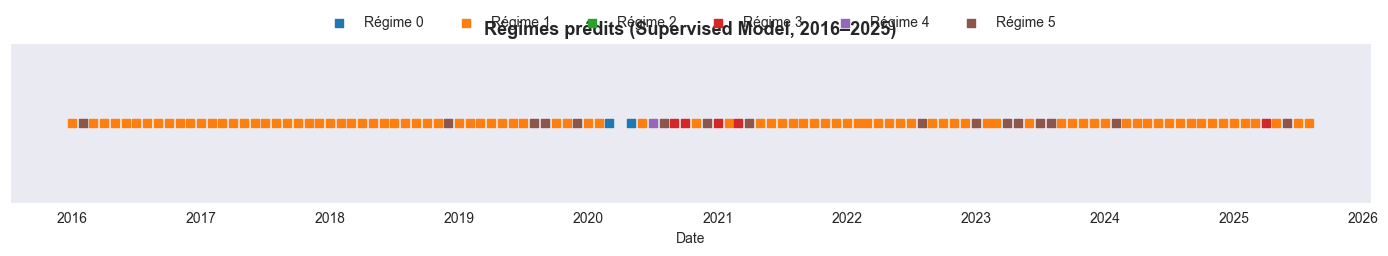

In [163]:
# ------------------------------------------------------------
reg_cols = [c for c in supervised_out.columns if c.startswith("reg_")]

gmm_labels_oos = (
    supervised_out.loc["2016-01-01":, reg_cols]
    .idxmax(axis=1)
    .str.extract(r"(\d+)").astype(int)[0]
    .rename("regime_pred")
)

dates_oos = gmm_labels_oos.index
n_regimes = gmm_labels_oos.max() + 1

# ------------------------------------------------------------
# 2) Palette + Figure
# ------------------------------------------------------------
palette = sns.color_palette("tab10", n_colors=n_regimes)

fig, ax = plt.subplots(figsize=(14, 2.8))
ax.set_title(f"Régimes prédits (Supervised Model, 2016–{dates_oos[-1].year})",
             fontsize=13, weight="bold")

# Timeline colorée (même style que GMM)
for k_ in range(n_regimes):
    idx_k = gmm_labels_oos[gmm_labels_oos == k_].index
    ax.scatter(idx_k, [0]*len(idx_k),
               s=35, color=palette[k_],
               label=f"Régime {k_}", marker="s")

# ------------------------------------------------------------
# 3) Mise en forme
# ------------------------------------------------------------
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=min(6, n_regimes),
    frameon=False
)

plt.tight_layout()
plt.show()


In [164]:
print(gmm_labels_oos)

sasdate
2016-01-01    1
2016-02-01    5
2016-03-01    1
2016-04-01    1
2016-05-01    1
             ..
2025-04-01    3
2025-05-01    1
2025-06-01    5
2025-07-01    1
2025-08-01    1
Name: regime_pred, Length: 115, dtype: int64


## Construction de portefeuille

Pour rappel on liste les df utiles :

In [165]:
# indus_cum : dataframe des rendements industry cumulés
# res_kmeans : dataframe résultats kmeans regime detection avant 2016 IS
#  indus_df : dataframe des rendements industry bruts

# indus_IS : dataframe des rendements industry bruts IS
# indus_OOS : dataframe des rendements industry bruts OOS

indus_IS.head()


,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
1962-09-01,-5.61,-2.20,-7.13,-1.77,-3.21,-9.37,-6.06,-2.87,-6.63,-4.05,-5.69,-5.81
1962-10-01,-3.27,2.46,-0.20,-0.29,4.26,0.01,2.77,-1.09,-1.34,2.46,-0.74,1.46
1962-11-01,12.12,6.82,13.85,10.75,12.10,14.82,7.17,7.65,11.16,17.63,14.09,15.25
1962-12-01,1.45,3.54,-1.72,4.69,0.84,-0.70,1.08,3.48,0.04,0.88,1.66,1.21
1963-01-01,5.94,7.60,6.14,2.68,4.62,6.11,4.13,5.25,4.13,5.66,3.60,6.29


### Calcul des moments conditionnels

In [166]:
def conditional_moments(
    returns_df: pd.DataFrame,
    regimes_df: pd.DataFrame,
    label_col: str = "kmeans_label",
    cols: list[str] | None = None,
    min_obs: int = 12,
) -> tuple[pd.DataFrame, pd.DataFrame, dict[int, pd.DataFrame], pd.Series]:
    """
    Calcule E[R | régime], Std[R | régime], Cov[R | régime] avec alignement robuste des dates.

    Params
    ------
    returns_df : DataFrame
        Rendements (en proportions) indexés par Date.
    regimes_df : DataFrame
        Doit contenir une colonne `label_col` indexée par Date (mêmes unités temporelles).
    label_col : str
        Nom de la colonne contenant le label de régime.
    cols : list[str] | None
        Sous-ensemble de colonnes de returns à utiliser. Si None -> colonnes numériques.
    min_obs : int
        Nombre minimal d'observations par régime (sinon le régime est ignoré).

    Returns
    -------
    mean_df : DataFrame     # moyennes conditionnelles par régime
    std_df  : DataFrame     # écarts-types conditionnels par régime
    covs    : dict[int, DataFrame]  # matrices de covariance par régime
    n_by_regime : Series    # effectif par régime (après filtre)
    """

    # 1) Alignement des dates (intersection) en démarrant à la date commune la plus récente
    r0, g0 = returns_df.sort_index(), regimes_df.sort_index()
    start = max(r0.index.min(), g0.index.min())
    r1 = r0.loc[start:]
    g1 = g0.loc[start:]
    df = r1.join(g1[[label_col]], how="inner").dropna(subset=[label_col])

    # 2) Colonnes à utiliser
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.drop(label_col, errors="ignore")
    else:
        cols = pd.Index(cols).intersection(df.columns)

    # 3) Groupby et moments
    groups = dict(tuple(df.groupby(label_col)))
    means, stds, covs, counts = {}, {}, {}, {}
    for reg, sub in groups.items():
        subX = sub[cols].dropna(how="any")
        n = len(subX)
        if n >= min_obs:
            means[reg] = subX.mean()
            stds[reg]  = subX.std(ddof=1)
            covs[reg]  = subX.cov()
            counts[reg]= n

    # 4) Assemblage
    mean_df = pd.DataFrame(means).T.sort_index()
    std_df  = pd.DataFrame(stds).T.sort_index()
    n_by_regime = pd.Series(counts).sort_index()

    return mean_df, std_df, covs, n_by_regime


TypeError: unsupported operand type(s) for |: 'types.GenericAlias' and 'NoneType'

In [ ]:
# Vérification de l'alignement temporel
print("Période industries :", indus_IS.index.min(), "→", indus_IS.index.max())
print("Période régimes   :", res_kmeans.index.min(), "→", res_kmeans.index.max())

# Appel de la fonction généralisée
mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS = conditional_moments(
    returns_df = indus_IS,     # rendements bruts industries
    regimes_df = res_kmeans,    # régimes K-means in-sample
    label_col  = "kmeans_label",
    min_obs    = 12
)

# Aperçu des résultats
print("=== Moyennes conditionnelles par régime ===")
print(mean_ind_IS.round(4))
print("\n=== Volatilités conditionnelles ===")
print(std_ind_IS.round(4))
print("\n=== Effectif par régime ===")
print(n_ind_IS)

# Exemple : covariance du régime 0
print("\n=== Covariance régime 0 ===")
print(cov_ind_IS[0].round(4))

print(mean_ind_IS.head())


In [ ]:
# Si tu as déjà un DataFrame des régimes in-sample :
# res_kmeans  (index = dates, colonne 'kmeans_label')

mean_IS, std_IS, cov_IS = conditional_moments(ff_factors, res_kmeans)

print(mean_IS.round(4).head())
print(std_IS.round(4).head())
# Exemple: afficher la covariance du régime 0 (ou 1 selon tes labels)
print(cov_IS[sorted(cov_IS.keys())[0]].round(4))


In [ ]:
mean_df, std_df, covs = conditional_moments(ff_factors, res_kmeans)

print("E[R | régime] :")
print(mean_df.round(4))

print("\nVolatilité (écart-type) par régime :")
print(std_df.round(4))

# Exemple : matrice de covariance du régime 1
print("\nCovariance (régime 1) :")
print(covs[1].round(4))


### Construction de portefeuille

In [ ]:
# mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS : df des moments inconditionnels IS industries
# gmm_labels_oos : régime OSS pour le moment

In [ ]:
import numpy as np
import pandas as pd

def predicted_moments_from_regimes(
    regimes_pred: pd.Series,
    mean_IS: pd.DataFrame,
    std_IS: pd.DataFrame | None = None,
    cov_IS: dict[int, pd.DataFrame] | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame | None, dict | None]:
    """
    Sélectionne, à chaque date OOS, les moments conditionnels estimés en IS
    en fonction du régime prédit ce mois-là.

    Parameters
    ----------
    regimes_pred : pd.Series
        Régimes prédits (entiers 0..K-1), index = dates.
    mean_IS : DataFrame
        E[R|r] par régime (index = régimes) et par actif (colonnes).
    std_IS  : DataFrame, optional
        Std[R|r] par régime et par actif (mêmes dims que mean_IS).
    cov_IS  : dict[int -> DataFrame], optional
        Σ_r (covariances) pour chaque régime (mêmes colonnes que mean_IS).

    Returns
    -------
    mu_pred  : DataFrame  (dates × actifs)
    std_pred : DataFrame or None  (dates × actifs) si std_IS fourni
    cov_pred : dict[Timestamp -> DataFrame] or None  si cov_IS fourni
               (une matrice Σ sélectionnée par date)
    """
    # -- sécurisation des types/index
    if isinstance(regimes_pred, pd.DataFrame):
        regimes_pred = regimes_pred.iloc[:, 0]
    regimes_pred = regimes_pred.astype(int)
    dates = pd.to_datetime(regimes_pred.index)

    cols = list(mean_IS.columns)
    # Moyennes attendues par date (sélection du bon régime)
    mu_rows = [mean_IS.loc[k].values if k in mean_IS.index else np.zeros(len(cols))
               for k in regimes_pred.values]
    mu_pred = pd.DataFrame(mu_rows, index=dates, columns=cols)

    # Écarts-types attendus (si fournis)
    std_pred = None
    if std_IS is not None:
        std_rows = [std_IS.loc[k].values if k in std_IS.index else np.zeros(len(cols))
                    for k in regimes_pred.values]
        std_pred = pd.DataFrame(std_rows, index=dates, columns=cols)

    # Covariances attendues (si fournies)
    cov_pred = None
    if cov_IS is not None:
        cov_pred = {}
        for d, k in zip(dates, regimes_pred.values):
            cov_pred[d] = cov_IS[k].copy() if k in cov_IS else pd.DataFrame(
                np.zeros((len(cols), len(cols))), index=cols, columns=cols
            )

    return mu_pred, std_pred, cov_pred


In [ ]:
# mean_ind_IS, std_ind_IS, cov_ind_IS : moments IS par régime (industries)
# gmm_labels_oos : régimes prédits (Series, index=dates OOS)

mu_pred, std_pred, cov_pred = predicted_moments_from_regimes(
    regimes_pred = gmm_labels_oos,
    mean_IS = mean_ind_IS,
    std_IS  = std_ind_IS,
    cov_IS  = cov_ind_IS
)
    # idem


print(mu_pred.head())     # E[R|r(t)] par date
print(std_pred.head())    # σ[R|r(t)] par date (si fourni)
# print(cov_pred[next(iter(cov_pred))])  # une Σ_r(t) au hasard
